In [1]:
import math
import torch
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.modules.transformer import TransformerEncoderLayer

In [12]:
# Imports
import torch, math
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.modules.transformer import TransformerEncoderLayer

# Positional Encoding - https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# A forcasting model
class ForecastingModel(torch.nn.Module):
    def __init__(self,
                 seq_len=200,
                 embed_size = 16,
                 nhead = 4,
                 dim_feedforward = 2048,
                 dropout = 0.1,
                 conv1d_emb = True,
                 conv1d_kernel_size = 3,
                 device = "cuda"):
        super(ForecastingModel, self).__init__()

        # Set Class-level Parameters
        self.device = device
        self.conv1d_emb = conv1d_emb
        self.conv1d_kernel_size = conv1d_kernel_size
        self.seq_len = seq_len
        self.embed_size = embed_size

        # Input Embedding Component
        if conv1d_emb:
            if conv1d_kernel_size%2==0:
                raise Exception("conv1d_kernel_size must be an odd number to preserve dimensions.")
            self.conv1d_padding = conv1d_kernel_size - 1
            self.input_embedding  = nn.Conv1d(1, embed_size, kernel_size=conv1d_kernel_size)
        else: self.input_embedding  = nn.Linear(1, embed_size)

        # Positional Encoder Componet (See Code Copied from PyTorch Above)
        self.position_encoder = PositionalEncoding(d_model=embed_size,
                                                   dropout=dropout,
                                                   max_len=seq_len)

        # Transformer Encoder Layer Component
        self.transformer_encoder = TransformerEncoderLayer(
            d_model = embed_size,
            nhead = nhead,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            batch_first = True
        )

        # Regression Component
        self.linear1 = nn.Linear(seq_len*embed_size, int(dim_feedforward))
        self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
        self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
        self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
        self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
        self.outlayer = nn.Linear(int(dim_feedforward/64), 1)

        # Basic Components
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    # Model Forward Pass
    def forward(self, x):
        src_mask = self._generate_square_subsequent_mask()
        src_mask.to(self.device)
        if self.conv1d_emb:
            x = F.pad(x, (0, 0, self.conv1d_padding, 0), "constant", -1)
            x = self.input_embedding(x.transpose(1, 2))
            x = x.transpose(1, 2)
        else:
            x = self.input_embedding(x)
        x = self.position_encoder(x)
        x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len*self.embed_size))
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear5(x)
        x = self.relu(x)
        return self.outlayer(x)

    # Function Copied from PyTorch Library to create upper-triangular source mask
    def _generate_square_subsequent_mask(self):
        return torch.triu(
            torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1,
        )

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

DATA_SIZE = 1000
x = np.sin(np.linspace(0,10,DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)


seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1,1))
X.shape, Y.shape

((800, 200, 1), (800, 1))

In [16]:
device="cuda"
EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 2.2e-6
model = ForecastingModel(seq_len, embed_size=8, nhead=2, dim_feedforward=1024, dropout=0, device=device)
model.to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma = 0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE)

for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")

Epoch 1/30: Loss=0.1721486747264862
Epoch 2/30: Loss=0.07887953519821167
Epoch 3/30: Loss=0.006439514923840761
Epoch 4/30: Loss=0.000853034493047744
Epoch 5/30: Loss=0.0005824724212288857
Epoch 6/30: Loss=0.0014533731155097485
Epoch 7/30: Loss=0.002182793105021119
Epoch 8/30: Loss=0.002032884396612644
Epoch 9/30: Loss=0.001603972166776657
Epoch 10/30: Loss=0.001392469508573413
Epoch 11/30: Loss=0.0013734294334426522
Epoch 12/30: Loss=0.001312953419983387
Epoch 13/30: Loss=0.0012378293322399259
Epoch 14/30: Loss=0.0012547526275739074
Epoch 15/30: Loss=0.0014228045474737883
Epoch 16/30: Loss=0.0016479131300002337
Epoch 17/30: Loss=0.001925100339576602
Epoch 18/30: Loss=0.0021870050113648176
Epoch 19/30: Loss=0.002451230539008975
Epoch 20/30: Loss=0.0027007246389985085
Epoch 21/30: Loss=0.002931407419964671
Epoch 22/30: Loss=0.0031149270944297314
Epoch 23/30: Loss=0.0032544590067118406
Epoch 24/30: Loss=0.003386993892490864
Epoch 25/30: Loss=0.003493606811389327
Epoch 26/30: Loss=0.003582

In [7]:
len(x), x.shape

(1000, (1000,))

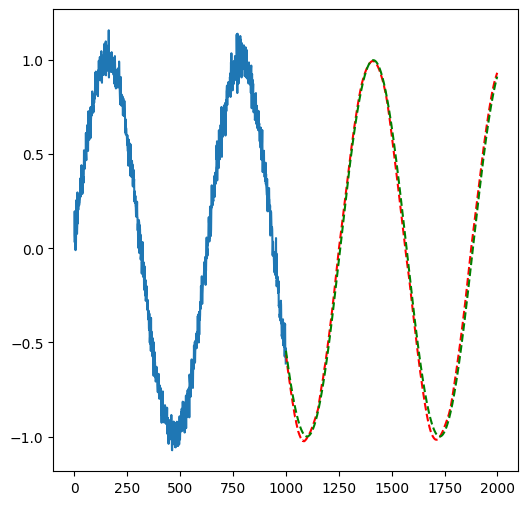

In [29]:
FORECAST = 1000
model.eval()
for ff in range(FORECAST):
  xx = x[len(x)-seq_len:len(x)]
  yy = model(torch.Tensor(xx).reshape(1,xx.shape[0],1).to(device))
  x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORECAST], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10,20,DATA_SIZE)), 'g--', label="Actual")


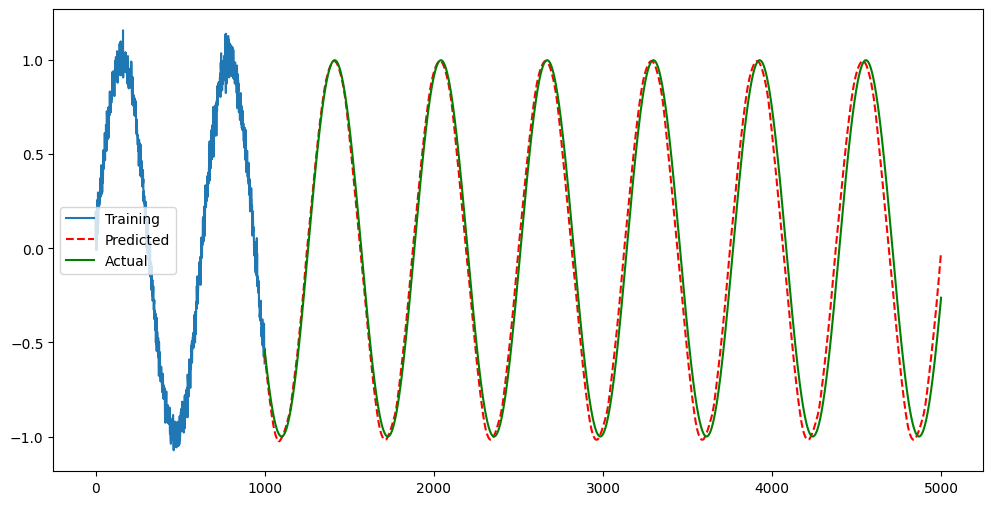

In [30]:

# Prediction Loop
FORCAST_EXTENDED = 3000
model.eval()
for ff in range(FORCAST_EXTENDED):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORECAST+FORCAST_EXTENDED], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 50, FORECAST+FORCAST_EXTENDED)), 'g-', label="Actual")
plt.legend()
plt.show()
# fig.savefig("./img/sine_extended.png")

Sunspots_Example

In [35]:
import pandas as pd
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import (mean_squared_error, mean_absolute_error)

In [61]:
seq_len = 200
data = list(pd.read_csv("sunspots.csv")["Monthly Mean Total Sunspot Number"])[1000:]
x = np.array(data[:2000])
forecast = np.array(data[2000:])
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape(-1, seq_len,1)
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape(-1,1)
X.shape, Y.shape

((1800, 200, 1), (1800, 1))

In [59]:
device = 'cuda'
EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 6.6E-6
model = ForecastingModel(seq_len, embed_size=8, nhead=2, dim_feedforward=1024, dropout=0,conv1d_emb=False, conv1d_kernel_size=5, device=device).to(device)

model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE)

for epoch in range(EPOCHS):
  for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
  scheduler.step()
  print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")

Epoch 1/30: Loss=46.732215881347656
Epoch 2/30: Loss=51.59703826904297
Epoch 3/30: Loss=17.28570556640625
Epoch 4/30: Loss=18.289306640625
Epoch 5/30: Loss=19.748443603515625
Epoch 6/30: Loss=21.173233032226562
Epoch 7/30: Loss=22.125221252441406
Epoch 8/30: Loss=22.888153076171875
Epoch 9/30: Loss=23.53174591064453
Epoch 10/30: Loss=24.294143676757812
Epoch 11/30: Loss=24.542327880859375
Epoch 12/30: Loss=24.217010498046875
Epoch 13/30: Loss=23.674583435058594
Epoch 14/30: Loss=22.778045654296875
Epoch 15/30: Loss=22.443115234375
Epoch 16/30: Loss=22.330520629882812
Epoch 17/30: Loss=22.25579833984375
Epoch 18/30: Loss=22.281089782714844
Epoch 19/30: Loss=22.00684356689453
Epoch 20/30: Loss=21.780838012695312
Epoch 21/30: Loss=21.683792114257812
Epoch 22/30: Loss=21.79644775390625
Epoch 23/30: Loss=21.86902618408203
Epoch 24/30: Loss=21.835853576660156
Epoch 25/30: Loss=21.661949157714844
Epoch 26/30: Loss=21.414703369140625
Epoch 27/30: Loss=21.360992431640625
Epoch 28/30: Loss=21.31

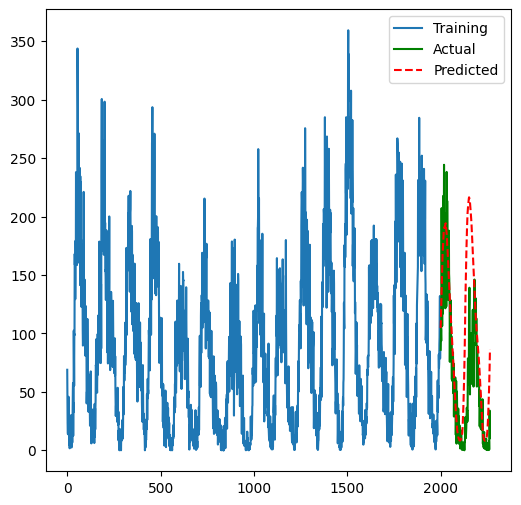

In [62]:
model.eval()
for ff in range(len(forecast)):
  xx = x[len(x)-seq_len:len(x)]
  yy =  model(torch.Tensor(xx).reshape((1, seq_len, 1)).to(device))
  x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.plot(range(2000), data[:2000], label="Training")
plt.plot(range(2000, len(data)), forecast, 'g-', label="Actual")
plt.plot(range(2000, len(data)), x[2000:], 'r--', label="Predicted")
plt.legend()
plt.show()

In [63]:
# Export Metrics
print(f"MSE: {mean_squared_error(x[2000:], forecast)}")
print(f"MAE: {mean_absolute_error(x[2000:], forecast)}")

MSE: 3286.5212505096624
MAE: 38.1021732020828
